In [ ]:
import pandas as pd
import os
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving stock_details_5_years-1.csv to stock_details_5_years-1.csv


In [ ]:
df = pd.read_csv('stock_details_5_years-1.csv')

#this method may take too long to run, thus load the below importing method

# Data visualization, sample means, sample variance
gibbs sampling: trace plots, posterior histogram, plots of the ACF, one for each parameter
posterior means + 95% CI (inference)
VaR, ES, histogram of the distribution, mean + 95% CI
no more than 15 slides
report: division of labor, AI use, use LATEX, slides, link to presentation recording.




In [ ]:
dataframes = {}

folder_path = '/content/drive/MyDrive/Stats 211 Final project'

for file_name in os.listdir(folder_path):
  file_path = os.path.join(folder_path, file_name)
  if file_name.endswith('.csv'):
    dataframes[file_name] = pd.read_csv(file_path)
    print(f"Loaded {file_name} successfully.")

df = dataframes.get('Stock.csv') #for this to load on your colab, make sure that the 'Stats 211 Final Project' is on your 'My Drive' part. If it's not, I can help you.

Loaded Stock.csv successfully.


Data cleaning
*italicised text*

In [ ]:
df = df[
    ['Date', 'Close', 'Company'] #selecting usable columns
    ]

filtered_df = df[df['Company'].str.contains('AAPL', case=False, na=False)]

df = filtered_df.reset_index(drop=True)
df.index =df.index+1

df['Date'] = df['Date'].str.extract(r'(\d{4}-\d{2}-\d{2})')

df.head()

,Date,Close,Company
1,2018-11-29,43.083508,AAPL
2,2018-11-30,42.850754,AAPL
3,2018-12-03,44.348064,AAPL
4,2018-12-04,42.397247,AAPL
5,2018-12-06,41.924541,AAPL


In [ ]:
df.to_csv('cleaned_stock.csv', index=False)



In [ ]:
# @title 默认标题文本
from google.colab import files
files.download('cleaned_stock.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import gamma

def gibbs_sampling(df):
    """
    Gibbs Sampling for Normal(μ, τ^{-1}) Model with Normal-Gamma Priors
    """

    #----------------------------------------------------------------
    # 1. Use Existing df
    #----------------------------------------------------------------
    # df must already contain 'Close'
    df.dropna(subset=['Close'], inplace=True)

    #----------------------------------------------------------------
    # 2. Calculate Log Returns
    #----------------------------------------------------------------
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df.dropna(subset=['log_return'], inplace=True)
    data = df['log_return'].values
    n = len(data)
    x_bar = np.mean(data)


    #----------------------------------------------------------------
    # Priors:
    mu0 = 0.0         # Prior mean
    sigma0_squared = 1000  # Prior variance for mu
    alpha0 = 0.01      # Prior shape for tau
    beta0 = 0.01       # Prior rate for tau

    iterations = 5000
    burn_in = 1000

    mu_trace = np.zeros(iterations)
    tau_trace = np.zeros(iterations)

    # Initialize values
    mu_current = x_bar
    tau_current = 1.0 / np.var(data, ddof=1)

    # 4. Gibbs Sampling Loop
    #----------------------------------------------------------------
    for t in range(iterations):
        # (A) Update mu | tau, x
        sigma_n_squared = 1.0 / (n * tau_current + 1.0 / sigma0_squared)
        mu_n = sigma_n_squared * (n * tau_current * x_bar + mu0 / sigma0_squared)
        mu_current = np.random.normal(mu_n, np.sqrt(sigma_n_squared))

        # (B) Update tau | mu, x
        alpha_n = alpha0 + n / 2.0
        beta_n = beta0 + 0.5 * np.sum((data - mu_current)**2)
        tau_current = np.random.gamma(shape=alpha_n, scale=1.0/beta_n)

        # Store traces
        mu_trace[t] = mu_current
        tau_trace[t] = tau_current

    #----------------------------------------------------------------
    # 5. Post-processing
    #----------------------------------------------------------------
    mu_samples = mu_trace[burn_in:]
    tau_samples = tau_trace[burn_in:]

    mu_posterior_mean = np.mean(mu_samples)
    tau_posterior_mean = np.mean(tau_samples)
    sigma2_posterior_mean = np.mean(1.0 / tau_samples)

    # Print results
    print("===== Gibbs Sampling for Normal(μ, τ^{-1}) Model =====")
    print(f"Data size (n): {n}")
    print(f"Empirical mean of log_return: {x_bar:.6f}")
    print(f"-----------------------------------------------------")
    print(f"Posterior mean of mu:      {mu_posterior_mean:.6f}")
    print(f"Posterior mean of tau:     {tau_posterior_mean:.6f}")
    print(f"Posterior mean of sigma^2: {sigma2_posterior_mean:.6f}")
    print("======================================================")

    return mu_trace, tau_trace, mu_posterior_mean, tau_posterior_mean, sigma2_posterior_mean

# Example of running:
# mu_trace, tau_trace, mu_mean, tau_mean, sigma2_mean = gibbs_sampling(df)

if __name__ == "__main__":
    mu_trace, tau_trace, mu_mean, tau_mean, sigma2_mean = gibbs_sampling(df)



===== Gibbs Sampling for Normal(μ, τ^{-1}) Model =====
Data size (n): 1256
Empirical mean of log_return: 0.001185
-----------------------------------------------------
Posterior mean of mu:      0.001189
Posterior mean of tau:     2274.056850
Posterior mean of sigma^2: 0.000440


import matplotlib.pyplot as plt
def plot_trace(mu_trace, tau_trace, burn_in=1000):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    axs[0].plot(mu_trace[burn_in:])
    axs[0].set_title(r"Trace Plot of $\mu$ (after burn-in)")
    axs[0].set_xlabel("Iteration")
    axs[0].set_ylabel(r"$\mu$")

    axs[1].plot(tau_trace[burn_in:])
    axs[1].set_title(r"Trace Plot of $\tau$ (after burn-in)")
    axs[1].set_xlabel("Iteration")
    axs[1].set_ylabel(r"$\tau$")

    plt.tight_layout()
    plt.show()

plot_trace(mu_trace, tau_trace)


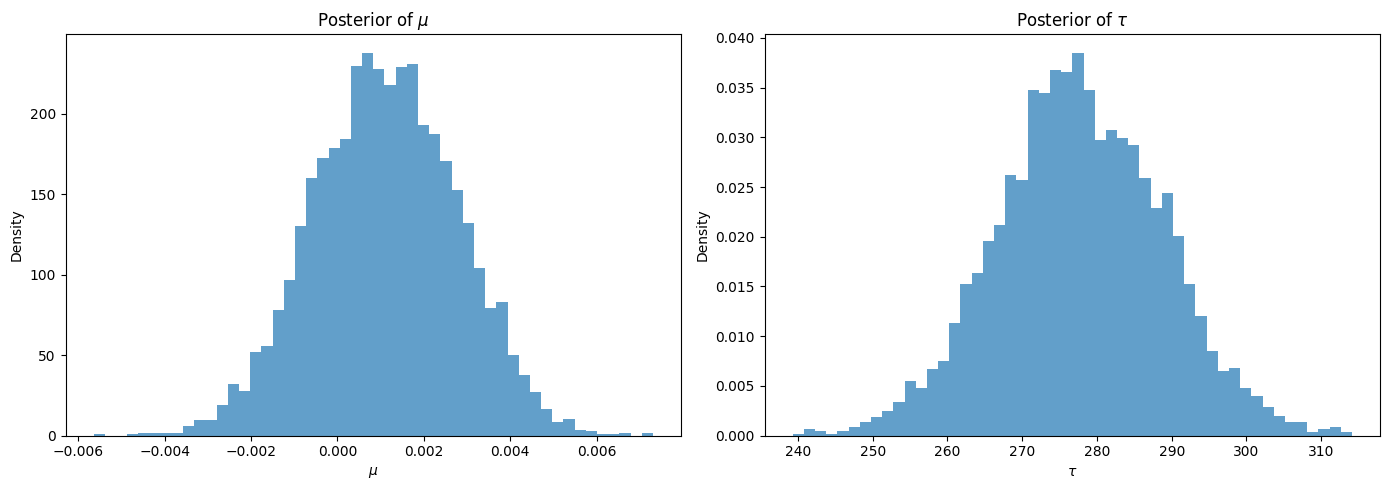

In [ ]:
def plot_posterior_histograms(mu_trace, tau_trace, burn_in=1000):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].hist(mu_trace[burn_in:], bins=50, density=True, alpha=0.7)
    axs[0].set_title(r"Posterior of $\mu$")
    axs[0].set_xlabel(r"$\mu$")
    axs[0].set_ylabel("Density")

    axs[1].hist(tau_trace[burn_in:], bins=50, density=True, alpha=0.7)
    axs[1].set_title(r"Posterior of $\tau$")
    axs[1].set_xlabel(r"$\tau$")
    axs[1].set_ylabel("Density")

    plt.tight_layout()
    plt.show()

plot_posterior_histograms(mu_trace, tau_trace)



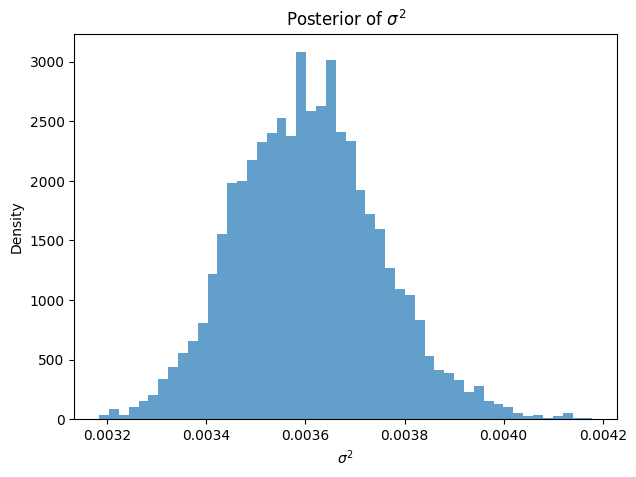

In [ ]:
def plot_sigma2_posterior(tau_trace, burn_in=1000):
    sigma2_samples = 1.0 / tau_trace[burn_in:]

    plt.figure(figsize=(7,5))
    plt.hist(sigma2_samples, bins=50, density=True, alpha=0.7)
    plt.title(r"Posterior of $\sigma^2$")
    plt.xlabel(r"$\sigma^2$")
    plt.ylabel("Density")
    plt.show()
plot_sigma2_posterior(tau_trace)


===== Gibbs Sampling for Normal(μ, τ^{-1}) Model =====
Data size (n): 1252
Empirical mean of log_return: 0.001236
-----------------------------------------------------
Posterior mean of mu:      0.001231
Posterior mean of tau:     277.040420
Posterior mean of sigma^2: 0.003615


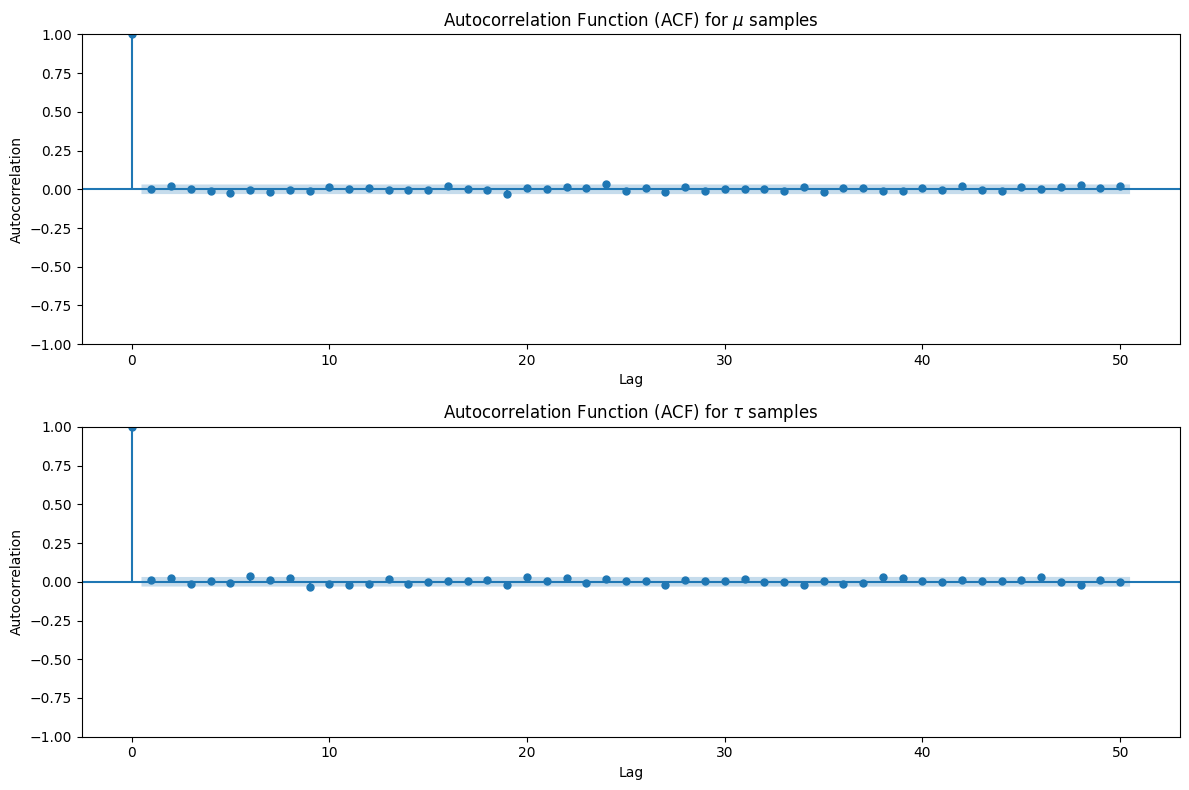

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

def plot_acf_traces(mu_trace, tau_trace, burn_in=1000, lags=50):
    """
    Plot ACF (Autocorrelation Function) for mu and tau traces after burn-in.

    Args:
        mu_trace: array of sampled mu
        tau_trace: array of sampled tau
        burn_in: number of burn-in iterations to discard
        lags: number of lags to show in ACF plots
    """
    # Remove burn-in
    mu_samples = mu_trace[burn_in:]
    tau_samples = tau_trace[burn_in:]

    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # ACF plot for mu
    plot_acf(mu_samples, lags=lags, ax=axs[0])
    axs[0].set_title(r"Autocorrelation Function (ACF) for $\mu$ samples")
    axs[0].set_xlabel("Lag")
    axs[0].set_ylabel("Autocorrelation")

    # ACF plot for tau
    plot_acf(tau_samples, lags=lags, ax=axs[1])
    axs[1].set_title(r"Autocorrelation Function (ACF) for $\tau$ samples")
    axs[1].set_xlabel("Lag")
    axs[1].set_ylabel("Autocorrelation")

    plt.tight_layout()
    plt.show()

    # After running your gibbs_sampling(df)
mu_trace, tau_trace, mu_mean, tau_mean, sigma2_mean = gibbs_sampling(df)

# Now plot ACFs
plot_acf_traces(mu_trace, tau_trace, burn_in=1000, lags=50)



In [ ]:
import numpy as np
from scipy.stats import norm

def compute_VaR_ES(mu_trace, tau_trace, burn_in=1000, alpha=0.95):
    """
    Compute VaR and Expected Shortfall (ES) from posterior samples of (mu, tau).

    Args:
        mu_trace: full array of sampled mu from Gibbs
        tau_trace: full array of sampled tau from Gibbs
        burn_in: number of burn-in iterations to discard
        alpha: confidence level (default 0.95)

    Returns:
        VaR_mean, ES_mean: point estimates (posterior means)
        VaR_CI, ES_CI: 95% credible intervals
        VaR_list, ES_list: full sample lists for further analysis if needed
    """
    # Remove burn-in samples
    mu_samples = mu_trace[burn_in:]
    tau_samples = tau_trace[burn_in:]

    n_samples = len(mu_samples)

    # Calculate sigma from tau (sigma = 1/sqrt(tau))
    sigma_samples = 1.0 / np.sqrt(tau_samples)

    # Critical value from standard normal
    z_alpha = norm.ppf(alpha)

    # Initialize arrays to store VaR and ES
    VaR_list = np.zeros(n_samples)
    ES_list = np.zeros(n_samples)

    # Calculate VaR and ES for each sample
    for i in range(n_samples):
        mu = mu_samples[i]
        sigma = sigma_samples[i]

        VaR = -(mu + z_alpha * sigma)
        ES = -(mu + (norm.pdf(z_alpha) / (1 - alpha)) * sigma)

        VaR_list[i] = VaR
        ES_list[i] = ES

    # Point estimates (posterior means)
    VaR_mean = np.mean(VaR_list)
    ES_mean = np.mean(ES_list)

    # 95% credible intervals (percentiles)
    VaR_CI = np.percentile(VaR_list, [2.5, 97.5])
    ES_CI = np.percentile(ES_list, [2.5, 97.5])

    return VaR_mean, ES_mean, VaR_CI, ES_CI, VaR_list, ES_list

# After your Gibbs sampling
mu_trace, tau_trace, mu_mean, tau_mean, sigma2_mean = gibbs_sampling(df)

# Then compute VaR and ES
VaR_mean, ES_mean, VaR_CI, ES_CI, VaR_list, ES_list = compute_VaR_ES(mu_trace, tau_trace, burn_in=1000, alpha=0.95)

# Print the results
print(f"===== Bayesian Risk Estimates =====")
print(f"Mean VaR (at 95%): {VaR_mean:.6f}")
print(f"95% CI for VaR: [{VaR_CI[0]:.6f}, {VaR_CI[1]:.6f}]")
print(f"Mean ES (at 95%): {ES_mean:.6f}")
print(f"95% CI for ES:  [{ES_CI[0]:.6f}, {ES_CI[1]:.6f}]")
print(f"====================================")


===== Gibbs Sampling for Normal(μ, τ^{-1}) Model =====
Data size (n): 1253
Empirical mean of log_return: 0.001206
-----------------------------------------------------
Posterior mean of mu:      0.001166
Posterior mean of tau:     277.389076
Posterior mean of sigma^2: 0.003611
===== Bayesian Risk Estimates =====
Mean VaR (at 95%): -0.099985
95% CI for VaR: [-0.105187, -0.094944]
Mean ES (at 95%): -0.125089
95% CI for ES:  [-0.131109, -0.119295]


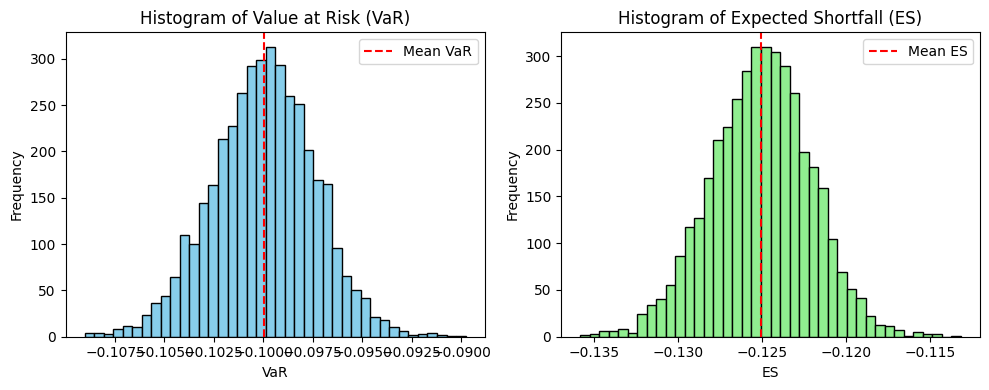

In [ ]:
import matplotlib.pyplot as plt

# Plot VaR distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(VaR_list, bins=40, color='skyblue', edgecolor='black')
plt.title('Histogram of Value at Risk (VaR)')
plt.xlabel('VaR')
plt.ylabel('Frequency')
plt.axvline(VaR_mean, color='red', linestyle='--', label='Mean VaR')
plt.legend()

# Plot ES distribution
plt.subplot(1, 2, 2)
plt.hist(ES_list, bins=40, color='lightgreen', edgecolor='black')
plt.title('Histogram of Expected Shortfall (ES)')
plt.xlabel('ES')
plt.ylabel('Frequency')
plt.axvline(ES_mean, color='red', linestyle='--', label='Mean ES')
plt.legend()

plt.tight_layout()
plt.show()


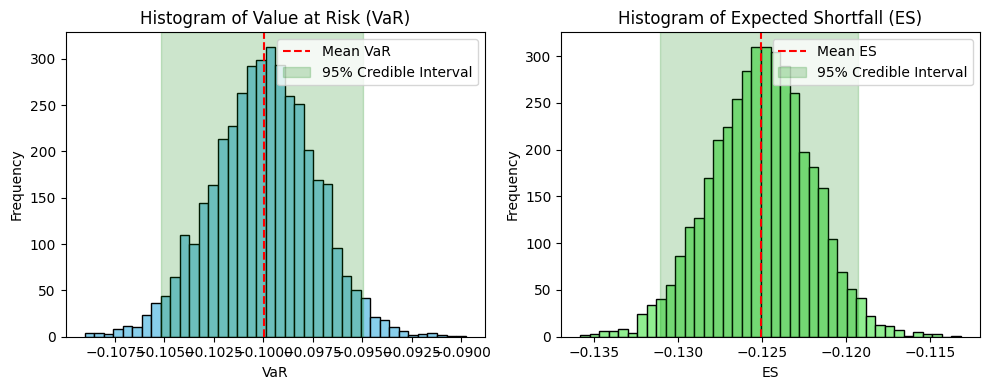

In [ ]:
import matplotlib.pyplot as plt

# Plot VaR distribution with 95% CI
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(VaR_list, bins=40, color='skyblue', edgecolor='black')
plt.title('Histogram of Value at Risk (VaR)')
plt.xlabel('VaR')
plt.ylabel('Frequency')

# Add mean line
plt.axvline(VaR_mean, color='red', linestyle='--', label='Mean VaR')

# Add 95% CI shaded area
plt.axvspan(VaR_CI[0], VaR_CI[1], color='green', alpha=0.2, label='95% Credible Interval')

plt.legend()

# Plot ES distribution with 95% CI
plt.subplot(1, 2, 2)
plt.hist(ES_list, bins=40, color='lightgreen', edgecolor='black')
plt.title('Histogram of Expected Shortfall (ES)')
plt.xlabel('ES')
plt.ylabel('Frequency')

# Add mean line
plt.axvline(ES_mean, color='red', linestyle='--', label='Mean ES')

# Add 95% CI shaded area
plt.axvspan(ES_CI[0], ES_CI[1], color='green', alpha=0.2, label='95% Credible Interval')

plt.legend()

plt.tight_layout()
plt.show()
